In [10]:
# SCRIPT 0: IMPORT LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS
from stargazer.stargazer import Stargazer
import os
disable_warnings = True
if disable_warnings:
    import warnings
    warnings.filterwarnings("ignore")

In [12]:
# SCRIPT 1: SETUP - DEFINE CONSTANTS AND TICKERS

TICKERS = {
    "Large Cap": [
        'EQNR.OL', 'DNB.OL', 'KOG.OL', 'MOWI.OL', 'TEL.OL', 'NHY.OL', 'AKRBP.OL',
        'ORK.OL', 'STB.OL', 'YAR.OL', 'SUBC.OL', 'GJF.OL', 'SALM.OL', 'TGS.OL',
        'TOM.OL', 'VAR.OL', 'NEL.OL', 'FRO.OL', 'BWLPG.OL', 'HAUTO.OL',
        'NOD.OL', 'WAWI.OL', 'NAS.OL', 'BAKKA.OL', 'WWI.OL', 'AFK.OL',
        'AUSS.OL', 'SCATC.OL', 'MPCC.OL', 'HAFNI.OL'
    ],
    "Mid Cap": [
        'AKER.OL', 'LSG.OL', 'KIT.OL', 'AKSO.OL', 'PARB.OL', 'BONHR.OL',
        'BOUV.OL', 'DNO.OL', 'ENTRA.OL', 'FLNG.OL', 'MING.OL', 'NAPA.OL',
        'NORBT.OL', 'OLT.OL', 'PCIB.OL', 'REACH.OL', 'WSTEP.OL', 'KOA.OL',
        'HSPG.OL', 'SOFF.OL', 'ABG.OL', 'BGBIO.OL', 'EMGS.OL', 'EXTX.OL',
        'HAVI.OL', 'HELG.OL', 'IDEX.OL', 'JIN.OL', 'MULTI.OL', 'NYKD.OL'
    ],
    "Small Cap": [
        'QEC.OL', 'RECSI.OL', 'SPOL.OL', 'AZT.OL', 'KID.OL', 'SATS.OL',
        'AURG.OL', 'PEN.OL', 'LINK.OL', 'PROT.OL', 'IOX.OL', 'ACC.OL',
        'TECH.OL', 'CONTX.OL', 'NONG.OL', 'BEWI.OL', 'ELO.OL', 'GSF.OL',
        'PRS.OL', 'AIRX.OL', 'OBSRV.OL', 'HUNT.OL', 'AKVA.OL', 'HEX.OL',
        'SOFTX.OL', 'ASA.OL', 'NORTH.OL', 'CAPSL.OL', 'LYTIX.OL', 'VOW.OL'
    ]
}

START_DATE = "2014-01-01"
END_DATE = "2024-12-31"
OUTPUT_CSV = "oslo_bors_labelled_data.csv"


In [13]:
# SCRIPT 1.1: CORWIN-SCHULTZ, ABDI-RANALDO, AND ROLL SPREAD ESTIMATORS
def corwin_schultz_spread(group):
    """
    Corwin-Schultz (2012) High-Low spread estimator.
    This function calculates a daily spread estimate.
    
    Reference: Corwin, S. A., & Schultz, P. (2012). A simple way to estimate 
    bid-ask spreads from daily high and low prices. The Journal of Finance, 67(2), 719-760.
    """
    group = group.sort_values('Date')
    
    high = group['High'].values
    low = group['Low'].values
    
    spreads = []
    negative_count = 0
    
    for i in range(len(group)):
        if i == 0:
            spreads.append(np.nan)
        else:
            h0, l0 = high[i], low[i]
            h1, l1 = high[i-1], low[i-1]
            
            if h0 > 0 and l0 > 0 and h1 > 0 and l1 > 0:
                beta = (np.log(h0/l0))**2 + (np.log(h1/l1))**2
                h_max = max(h0, h1)
                l_min = min(l0, l1)
                gamma = (np.log(h_max/l_min))**2
                
                k = (3 - 2*np.sqrt(2))
                alpha = (np.sqrt(2*beta) - np.sqrt(beta)) / k - np.sqrt(gamma / k)
                
                spread = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
                
                if spread >= 0:
                    spreads.append(spread)
                else:
                    spreads.append(np.nan)
                    negative_count += 1
            else:
                spreads.append(np.nan)
    
    if negative_count > 0:
        ticker = group['Ticker'].iloc[0] if 'Ticker' in group.columns else 'Unknown'
        # print(f"  Warning: {ticker} had {negative_count} negative Corwin-Schultz estimates (set to NaN)")
    
    group['Spread'] = spreads
    return group



def abdi_ranaldo_spread(group):
    """
    Calculates the NORMALIZED Abdi and Ranaldo (2017) "BAR" spread estimator.
    This version converts the absolute spread (in currency) to a relative 
    spread (as a percentage of the price), making it comparable across stocks.
    
    Note: Additional filtering is applied to remove economically meaningless spreads.
    """
    group = group.sort_values('Date')

    delta_p_t = group['Close'].diff()
    delta_p_t_minus_1 = delta_p_t.shift(1)

    if delta_p_t.count() < 2:
        return pd.Series(np.nan, index=group.index, name='Spread')

    cov_term = (delta_p_t * delta_p_t_minus_1)
    
    # Calculate the absolute spread (in currency units)
    absolute_spreads = 2 * np.sqrt(np.maximum(0, -cov_term))
    
    # NORMALIZATION STEP
    # To get a relative spread, divide by the average of today's and yesterday's close price.
    # Rolling window to get the average price at each point in time.
    avg_price = group['Close'].rolling(window=2, min_periods=1).mean()
    
    # Calculate the relative spread. Use .values to avoid index alignment issues.
    relative_spreads = absolute_spreads / avg_price.values
    
    # CRITICAL FIX: Filter out economically meaningless spreads
    # Spreads below 0.01% (0.0001) are likely measurement errors or rounding artifacts
    relative_spreads = np.where(relative_spreads < 0.0001, np.nan, relative_spreads)
    
    # Assign the comparable, relative spreads to the DataFrame
    group['Spread'] = relative_spreads
    return group



def get_roll_spread(group):
    """
    Roll (1984) spread estimator based on serial covariance of price changes.
    Returns a single spread estimate per stock (not time-varying).
    
    Roll's spread = 2 * sqrt(-Cov(ΔP_t, ΔP_t-1))
    
    The Roll estimator assumes that negative serial covariance in returns is 
    caused by bid-ask bounce. If the covariance is positive, it violates 
    Roll's model assumptions and we return NaN.
    
    Reference: Roll, R. (1984). A simple implicit measure of the effective 
    bid-ask spread in an efficient market. The Journal of Finance, 39(4), 1127-1139.
    """
    group = group.sort_values('Date')
    returns = group['Close'].pct_change().dropna()
    
    if len(returns) < 30:  # Minimum observations for reliable estimate
        return np.nan
    
    # Calculate serial covariance (covariance between returns and lagged returns)
    cov = returns.cov(returns.shift(1))
    
    # Roll's spread formula (only valid when covariance is negative)
    if pd.notna(cov) and cov < 0:
        spread = 2 * np.sqrt(-cov)
    else:
        # Positive covariance violates Roll's assumptions
        spread = np.nan
    
    return spread


In [14]:
# SCRIPT 1.2: ADD PERIOD LABELS FOR HOLIDAY ANALYSIS
def add_period_labels(df):
    """
    Adds period labels for holiday analysis.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    years = range(df['Date'].dt.year.min(), df['Date'].dt.year.max() + 1)
    norway_holidays = holidays.Norway(years=years)
    
    df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['month'] = df['Date'].dt.month
    df['period_label'] = 'control_year'

    for yr in years:
        christmas_ref_start = pd.Timestamp(f'{yr}-12-15')
        christmas_ref_end = pd.Timestamp(f'{yr}-12-31')
        christmas_days = pd.bdate_range(start=christmas_ref_start, end=christmas_ref_end, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
        
        if len(christmas_days) > 0:
            pre_christmas = pd.bdate_range(end=christmas_days[0] - pd.Timedelta(days=1), periods=5, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
            try:
                post_christmas_start = pd.Timestamp(f'{yr+1}-01-02')
                post_christmas = pd.bdate_range(start=post_christmas_start, periods=5, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
            except:
                post_christmas = pd.bdate_range(start=christmas_days[-1] + pd.Timedelta(days=1), periods=5, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
            
            df.loc[df['Date'].isin(pre_christmas), 'period_label'] = 'pre_christmas'
            df.loc[df['Date'].isin(christmas_days), 'period_label'] = 'christmas'
            df.loc[df['Date'].isin(post_christmas), 'period_label'] = 'post_christmas'

    for yr in years:
        easter_days = [d for d, h in norway_holidays.items() if ('Påske' in h or h in ['Skjærtorsdag', 'Langfredag']) and d.year == yr]
        
        if easter_days:
            easter_start = min(easter_days)
            easter_end = max(easter_days)
            pre_easter = pd.bdate_range(end=easter_start - pd.Timedelta(days=1), periods=5, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
            post_easter = pd.bdate_range(start=easter_end + pd.Timedelta(days=1), periods=5, freq='C', holidays=list(norway_holidays.keys()), weekmask='Mon Tue Wed Thu Fri')
            df.loc[df['Date'].isin(pre_easter), 'period_label'] = 'pre_easter'
            df.loc[df['Date'].isin(post_easter), 'period_label'] = 'post_easter'

    df.loc[df['week'].between(28, 30), 'period_label'] = 'summer_holiday'
    df.loc[(df['month'].between(6, 8)) & (~df['week'].between(28, 30)), 'period_label'] = 'summer_excl_holiday'

    return df


In [15]:
# SCRIPT 1.3: CHOOSE SPREAD ESTIMATOR (Simplified)
user_input = input("Which spread estimator do you want to use? (Enter 'CS' or 'AR'): ")

# Determine the spread method based on user input
if user_input.upper() == 'AR':
    METHOD_CHOICE = 'AR'
    SPREAD_METHOD_NAME = 'Abdi & Ranaldo (2017) Spread'
else:
    METHOD_CHOICE = 'CS'
    SPREAD_METHOD_NAME = 'Corwin-Schultz (2012) Spread'

print(f"The analysis will use the '{SPREAD_METHOD_NAME}'")


The analysis will use the 'Corwin-Schultz (2012) Spread'


In [16]:
# SCRIPT 1.4: CHOOSE MULTIPLE TESTING CORRECTION METHOD

correction_input = input(
    "Which multiple testing correction do you want to use for significance?\n(Enter 'B' or 'FDR')").strip().lower()

if correction_input == 'fdr':
    CORRECTION_METHOD = 'FDR'
    CORRECTION_METHOD_NAME = 'FDR (Benjamini-Hochberg)'
elif correction_input == 'B':
    CORRECTION_METHOD = 'Bonferroni'
    CORRECTION_METHOD_NAME = 'Bonferroni'
else:
    print("Invalid input - using FDR by default.")
    CORRECTION_METHOD = 'FDR'
    CORRECTION_METHOD_NAME = 'FDR (Benjamini-Hochberg)'

print(f"The analysis will use the '{CORRECTION_METHOD_NAME}' correction method.")


The analysis will use the 'FDR (Benjamini-Hochberg)' correction method.


In [17]:
# SCRIPT 1.5: MAIN DATA PROCESSING FUNCTION

def main():
    
    all_tickers = [ticker for sublist in TICKERS.values() for ticker in sublist]
    print(f"\nDownloading data for {len(all_tickers)} tickers...")
    print(f"Date range: {START_DATE} to {END_DATE}")
    
    raw_data = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=True, auto_adjust=True)

    if raw_data.empty:
        print("ERROR: No data downloaded")
        return

    print("TRANSFORMING DATA STRUCTURE: ")
    df = raw_data.stack(future_stack=True).reset_index()
    df = df.rename(columns={'level_1': 'Ticker'})
    
    ticker_to_cap = {ticker: cap for cap, tickers in TICKERS.items() for ticker in tickers}
    df['Cap_Group'] = df['Ticker'].map(ticker_to_cap)
    
    initial_len = len(df)
    df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume', 'Cap_Group'], inplace=True)
    print(f"Removed {initial_len - len(df):,} rows with missing price/volume data")

    # Spread Calculation
    print("\n")
    if METHOD_CHOICE == 'CS':
        print("CALCULATING CORWIN-SCHULTZ SPREADS (DAILY ESTIMATE)")
        df = df.groupby('Ticker', group_keys=False).apply(corwin_schultz_spread)
    elif METHOD_CHOICE == 'AR':
        print("CALCULATING ABDI & RANALDO (2017) 'BAR' SPREADS")
        df = df.groupby('Ticker', group_keys=False).apply(abdi_ranaldo_spread)
    else:
        raise ValueError("Invalid method choice. Please choose 'CS' or 'AR'.")
    print("Spread calculation complete.")

    # CRITICAL FIX: COMPREHENSIVE SPREAD DIAGNOSTICS
    print("\n")
    print(f"SPREAD DISTRIBUTION DIAGNOSTICS - {METHOD_CHOICE}")
    
    # Count spread values by category
    total_obs = len(df)
    zero_spreads = (df['Spread'] == 0).sum()
    negative_spreads = (df['Spread'] < 0).sum()
    tiny_spreads = ((df['Spread'] > 0) & (df['Spread'] < 0.0001)).sum()
    valid_spreads = (df['Spread'] >= 0.0001).sum()
    nan_spreads = df['Spread'].isna().sum()
    
    print(f"\nSpread Value Distribution:")
    print(f"  Total observations:        {total_obs:,}")
    print(f"  Zero values (= 0):         {zero_spreads:,} ({zero_spreads/total_obs*100:.2f}%)")
    print(f"  Negative values (< 0):     {negative_spreads:,} ({negative_spreads/total_obs*100:.2f}%)")
    print(f"  Tiny spreads (0 to 0,01%): {tiny_spreads:,} ({tiny_spreads/total_obs*100:.2f}%)")
    print(f"  Valid spreads (≥ 0,01%):   {valid_spreads:,} ({valid_spreads/total_obs*100:.2f}%)")
    print(f"  Missing (NaN):             {nan_spreads:,} ({nan_spreads/total_obs*100:.2f}%)")
    
    # Percentile analysis
    print(f"\nSpread Percentiles (before filtering):")
    percentiles = df['Spread'].describe(percentiles=[.01, .05, .10, .25, .50, .75, .90, .95, .99])
    for stat in ['min', '1%', '5%', '10%', '25%', '50%', '75%', '90%', '95%', '99%', 'max']:
        if stat in percentiles.index:
            print(f"  {stat:>5}: {percentiles[stat]:.6f}")
    
    # Warning if median is zero or very low
    median_spread = df['Spread'].median()
    if median_spread == 0:
        print("\nWARNING: Median spread is ZERO!")
        print("   - This indicates a data quality issue with the spread estimator.")
        print("   - Most observations have zero spread, which is economically unrealistic.")
    elif median_spread < 0.0001:
        print(f"\nWARNING: Median spread is very low ({median_spread:.6f})")
        print("   - Many spreads may be economically meaningless.")
    else:
        print(f"\nMedian spread: {median_spread:.6f} (appears reasonable)")

    # Data Quality Check and Cleaning
    print(f"DATA QUALITY FILTERING - {METHOD_CHOICE}")
    
    spread_before = len(df)
    
    # Remove NaN spreads
    df = df.dropna(subset=['Spread'])
    nan_removed = spread_before - len(df)
    print(f"\nRemoved {nan_removed:,} rows with NaN spreads")
    
    # CRITICAL FIX: Remove economically meaningless spreads
    # Spreads below 0.01% (1 basis point) are likely measurement errors 
    spread_before_filter = len(df)
    df = df[df['Spread'] >= 0.0001]
    tiny_removed = spread_before_filter - len(df)
    print(f"Removed {tiny_removed:,} rows with spreads < 0.01% (1 bp)")
    print(f"These are economically meaningless and likely measurement errors")
    
    print(f"\nTotal rows removed: {spread_before - len(df):,}")
    print(f"Remaining observations: {len(df):,}")
    
    # Post-filtering diagnostics
    print(f"\nPOST-FILTERING SPREAD STATISTICS:")
    print(f"  Mean:   {df['Spread'].mean():.6f}")
    print(f"  Median: {df['Spread'].median():.6f}")
    print(f"  Std:    {df['Spread'].std():.6f}")
    print(f"  Min:    {df['Spread'].min():.6f}")
    print(f"  Max:    {df['Spread'].max():.6f}")

    # Roll's Spread Calculation
    roll_spreads = df.groupby('Ticker').apply(get_roll_spread)
    df['RollsSpread'] = df['Ticker'].map(roll_spreads)
    
    valid_rolls = roll_spreads.notna().sum()
    total_tickers = df['Ticker'].nunique()
    invalid_rolls = total_tickers - valid_rolls
    
    print(f"\nRoll's spread calculation summary:")
    print(f"  Tickers with valid spread: {valid_rolls} / {total_tickers}")
    if invalid_rolls > 0:
        print(f"  Tickers with invalid spread: {invalid_rolls}")
        print(f"   - Likely due to positive serial covariance (violates Roll's assumptions)")
    print(f"  Average Roll's spread: {roll_spreads.mean():.6f}")
    
    # Compare Roll with CS/AR
    avg_cs_ar = df.groupby('Ticker')['Spread'].mean()
    comparison = pd.DataFrame({
        'Roll': roll_spreads,
        'CS_AR_Avg': avg_cs_ar
    }).dropna()
    
    if len(comparison) > 0:
        correlation = comparison.corr().iloc[0, 1]
        print(f"\nCorrelation between Roll and {METHOD_CHOICE} average: {correlation:.3f}")
        if correlation > 0.7:
            print(f" - Strong correlation indicates reliable spread estimates!")
        elif correlation > 0.5:
            print(f" - Moderate correlation - spread estimates are reasonably consistent")
        else:
            print(f"Low correlation - may indicate measurement issues")

    # Period Labeling and Final Export
    df = add_period_labels(df)
    
    
    final_cols = ['Date', 'Ticker', 'Cap_Group', 'Open', 'High', 'Low', 'Close', 
                  'Volume', 'Spread', 'RollsSpread', 'period_label']
    df_final = df[[col for col in final_cols if col in df.columns]]
    df_final.to_csv(OUTPUT_CSV, index=False)
    
    print(f"\nData saved to: {OUTPUT_CSV}")
    print(f"Total observations: {len(df_final):,}")
    print(f"Date range: {df_final['Date'].min()} to {df_final['Date'].max()}")
    print(f"Tickers: {df_final['Ticker'].nunique()}")
    
    # Final summary by cap group
    print(f"\n FINAL SPREAD SUMMARY BY CAP GROUP:")
    summary = df_final.groupby('Cap_Group')['Spread'].agg(['count', 'mean', 'median', 'std'])
    summary.columns = ['Observations', 'Mean', 'Median', 'Std Dev']
    print(summary.to_string())


if __name__ == "__main__":
    main()



Date range: 2014-01-01 to 2024-12-31


[*********************100%***********************]  90 of 90 completed

1 Failed download:
['FLNG.OL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-01-01 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")')


TRANSFORMING DATA STRUCTURE: 
Removed 35,978 rows with missing price/volume data


CALCULATING CORWIN-SCHULTZ SPREADS (DAILY ESTIMATE)
Spread calculation complete.


SPREAD DISTRIBUTION DIAGNOSTICS - CS

Spread Value Distribution:
  Total observations:        212,602
  Zero values (= 0):         11,525 (5.42%)
  Negative values (< 0):     0 (0.00%)
  Tiny spreads (0 to 0,01%): 1,199 (0.56%)
  Valid spreads (≥ 0,01%):   117,883 (55.45%)
  Missing (NaN):             81,995 (38.57%)

Spread Percentiles (before filtering):
    min: 0.000000
     1%: 0.000000
     5%: 0.000000
    10%: 0.000184
    25%: 0.004364
    50%: 0.010342
    75%: 0.019576
    90%: 0.033479
    95%: 0.045767
    99%: 0.080270
    max: 0.408711

Median spread: 0.010342 (appears reasonable)
DATA QUALITY FILTERING - CS

Removed 81,995 rows with NaN spreads
Removed 12,724 rows with spreads < 0.01% (1 bp)
These are economically meaningless and likely measurement errors

Total rows removed: 94,719
Remaining observations: 

METHODOLOGICAL SPLIT-SAMPLE DESIGN IMPLEMENTED
In-Sample Data (2014-2019):     54,944 observations (Used for analysis/regression)
Out-of-Sample Data (2020-2024): 62,939 observations (Used ONLY for backtesting)

Total observations (In-Sample): 54,944
Date range: 2014-01-03 00:00:00 to 2019-12-30 00:00:00
Unique tickers: 78
Trading days: 1,499

Cohen's d Effect Sizes (vs. Control Period):
 Summer Holiday: d = -0.1349
 Christmas: d = 0.1539
 Pre-Easter: d = -0.0293
 Post-Easter: d = -0.0038

Interpretation: |d| > 0.5 = medium to large effect
HARRIS FRAMEWORK: DEALER BEHAVIOR HYPOTHESIS

Testing Harris's prediction: Spreads should increase when volume decreases
(Lower dealer participation and higher inventory risk)

Spread by Volume Quartile:
                 Spread_Mean  Spread_Median  N_Obs    Avg_Volume
Volume_Quartile                                                 
Q1_Lowest           0.016526       0.010713  13736  5.310352e+03
Q2_Low              0.015488       0.010898  13736  6.20

NameError: name 'monthly_stats' is not defined

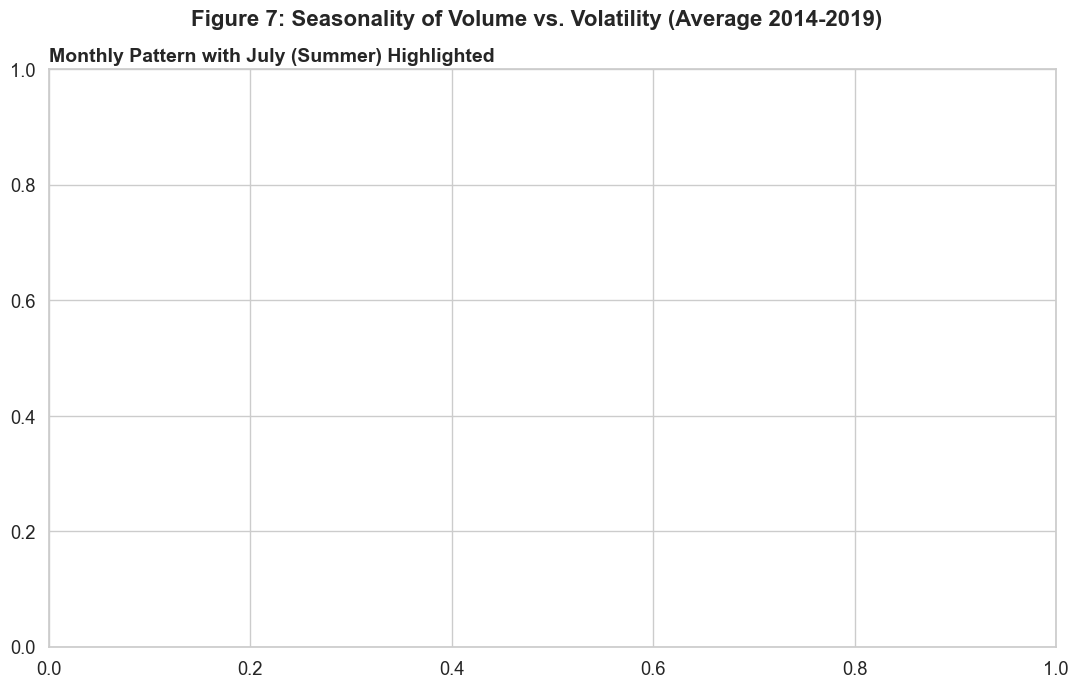

In [ ]:
# SCRIPT 2: DESCRIPTIVE STATISTICS AND VISUALIZATION
# Load Data
try:
    df = pd.read_csv('oslo_bors_labelled_data.csv', parse_dates=['Date'])
except FileNotFoundError:
    print("ERROR: 'oslo_bors_labelled_data.csv' not found.")
if not os.path.exists('output'):
    os.makedirs('output')

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# CRITICAL STEP: SPLIT SAMPLE DESIGN 
# Split data into In-Sample (Discovery) and Out-of-Sample (Validation)
# In-Sample: 2014-2019 (Used for descriptive stats, regressions, establishing the effect)
# Out-of-Sample: 2020-2024 (Used ONLY for backtesting trading strategies)

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Create the two distinct datasets
df_in_sample = df[df['Year'] <= 2019].copy()
df_out_of_sample = df[df['Year'] >= 2020].copy()

print("METHODOLOGICAL SPLIT-SAMPLE DESIGN IMPLEMENTED")
print(f"In-Sample Data (2014-2019):     {len(df_in_sample):,} observations (Used for analysis/regression)")
print(f"Out-of-Sample Data (2020-2024): {len(df_out_of_sample):,} observations (Used ONLY for backtesting)")

# IMPORTANT: Overwrite 'df' to be only in-sample data for the rest of the analysis (Script 2-5)
# This is to ensure that tables and graphs do not "see" the future.
df_full_backup = df.copy()
df = df_in_sample 

# Dataset overview (In-Sample)
print(f"\nTotal observations (In-Sample): {len(df):,}")
try:
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Unique tickers: {df['Ticker'].nunique()}")
    print(f"Trading days: {df['Date'].nunique():,}")
except:
    pass

# CRITICAL ADDITION: COHEN'S D EFFECT SIZE CALCULATION

def calculate_cohens_d(group1, group2):
    if len(group1) < 2 or len(group2) < 2: return np.nan
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    if pooled_std == 0: return 0
    d = (group1.mean() - group2.mean()) / pooled_std
    return d

# Calculate effect sizes for key holiday periods
control = df[df['period_label'] == 'control_year']['Spread']
summer = df[df['period_label'] == 'summer_holiday']['Spread']
christmas = df[df['period_label'] == 'christmas']['Spread']
easter_pre = df[df['period_label'] == 'pre_easter']['Spread']
easter_post = df[df['period_label'] == 'post_easter']['Spread']

print("\nCohen's d Effect Sizes (vs. Control Period):")
print(f" Summer Holiday: d = {calculate_cohens_d(summer, control):.4f}")
print(f" Christmas: d = {calculate_cohens_d(christmas, control):.4f}")
print(f" Pre-Easter: d = {calculate_cohens_d(easter_pre, control):.4f}")
print(f" Post-Easter: d = {calculate_cohens_d(easter_post, control):.4f}")
print("\nInterpretation: |d| > 0.5 = medium to large effect")

# CRITICAL ADDITION: HARRIS FRAMEWORK - DEALER BEHAVIOR HYPOTHESIS TEST
print("HARRIS FRAMEWORK: DEALER BEHAVIOR HYPOTHESIS")
print("\nTesting Harris's prediction: Spreads should increase when volume decreases")
print("(Lower dealer participation and higher inventory risk)")

df['Volume_Quartile'] = pd.qcut(df['Volume'], q=4, labels=['Q1_Lowest', 'Q2_Low', 'Q3_High', 'Q4_Highest'], duplicates='drop')

spread_by_volume = df.groupby('Volume_Quartile', observed=True).agg({
    'Spread': ['mean', 'median', 'count'],
    'Volume': 'mean'
}).round(6)
spread_by_volume.columns = ['Spread_Mean', 'Spread_Median', 'N_Obs', 'Avg_Volume']

print("\nSpread by Volume Quartile:")
print(spread_by_volume)

q1_spread = df[df['Volume_Quartile'] == 'Q1_Lowest']['Spread']
q4_spread = df[df['Volume_Quartile'] == 'Q4_Highest']['Spread']
t_stat, p_val = ttest_ind(q1_spread.dropna(), q4_spread.dropna(), equal_var=False)
cohens_d_volume = calculate_cohens_d(q1_spread.dropna(), q4_spread.dropna())

print(f"\nHarris Hypothesis Test:")
print(f" H0: Spread(Low Volume) = Spread(High Volume)")
print(f" H1: Spread(Low Volume) > Spread(High Volume)")
try:
    print(f" Mean spread Q1 (low vol): {q1_spread.mean():.6f}")
    print(f" Mean spread Q4 (high vol): {q4_spread.mean():.6f}")
    print(f" Difference: {q1_spread.mean() - q4_spread.mean():.6f}")
    print(f" t-statistic: {t_stat:.4f}")
    print(f" p-value: {p_val:.4f}")
    print(f" Cohen's d: {cohens_d_volume:.4f}")

    if p_val < 0.05 and q1_spread.mean() > q4_spread.mean():
        print(" ✓ RESULT: Harris's prediction CONFIRMED (p < 0.05)")
        print(" - Spreads are wider when volume is low (dealer participation reduced)")
    elif p_val < 0.05 and q1_spread.mean() < q4_spread.mean():
        print(" ✗ RESULT: Harris's prediction CONTRADICTED (p < 0.05)")
        print(" - Modern electronic markets may behave differently than Harris predicted")
    else:
        print(" -  RESULT: No significant relationship (p >= 0.05)")
except:
    print("Insufficient data for Harris test.")


# Summary by cap group
print("SUMMARY BY CAP GROUP")
summary_cap = df.groupby('Cap_Group').agg({
    'Spread': ['mean', 'median', 'std'],
    'Volume': ['mean', 'median'],
    'Ticker': 'nunique'
}).round(6)
summary_cap.columns = ['Spread_Mean', 'Spread_Median', 'Spread_Std', 'Volume_Mean', 'Volume_Median', 'N_Stocks']
print(summary_cap)


# HARRIS INTERPRETATION
print("\n HARRIS INTERPRETATION:")
print(" Large Cap stocks have narrower spreads due to:")
print(" - Higher competitive market making (Harris Chapter 6)")
print(" - Lower inventory risk for dealers")
print(" - Greater participation rates (Harris Chapter 21)")


# Summary by period
print("SUMMARY BY PERIOD")
summary_period = df.groupby('period_label').agg({
    'Spread': ['mean', 'median'],
    'Volume': ['mean', 'median'],
    'Date': 'count'
}).round(6)
summary_period.columns = ['Spread_Mean', 'Spread_Median', 'Volume_Mean', 'Volume_Median', 'N_Obs']
print(summary_period)


# Calculate percentage changes vs control
try:
    control_spread = summary_period.loc['control_year', 'Spread_Mean']
    control_volume = summary_period.loc['control_year', 'Volume_Mean']
    summary_period['Spread_Change_%'] = ((summary_period['Spread_Mean'] - control_spread) / control_spread * 100).round(2)
    summary_period['Volume_Change_%'] = ((summary_period['Volume_Mean'] - control_volume) / control_volume * 100).round(2)

    print("CHANGES VS CONTROL PERIOD")
    print(summary_period[['Spread_Mean', 'Spread_Change_%', 'Volume_Mean', 'Volume_Change_%']])
except KeyError:
    print("Control year not found in summary.")


summary_cap.to_csv('output/summary_by_cap.csv')
summary_period.to_csv('output/summary_by_period.csv')


# CRITICAL ADDITION: PRACTICAL IMPLICATIONS (NOK COST SAVINGS)
print("PRACTICAL IMPLICATIONS: TRADING COST ANALYSIS")

trade_sizes = [100000, 500000, 1000000, 5000000] # NOK
avg_stock_price = 100 # We assume 100 NOK per share

try:
    spread_control = summary_period.loc['control_year', 'Spread_Mean']
    spread_summer = summary_period.loc['summer_holiday', 'Spread_Mean']
    spread_diff = spread_summer - spread_control

    print(f"\nSpread difference (Summer vs. Control): {spread_diff:.6f}")
    print(f"Average stock price assumed: {avg_stock_price} NOK\n")

    print("Cost Impact per Trade (one-way):")
    print(f"{'Trade Size (NOK)':>20} {'Control Cost':>15} {'Summer Cost':>15} {'Savings':>15}")
    print("-" * 70)

    for trade_size in trade_sizes:
        shares = trade_size / avg_stock_price
        cost_control = shares * avg_stock_price * spread_control / 2 # Half-spread for one-way
        cost_summer = shares * avg_stock_price * spread_summer / 2
        savings = cost_control - cost_summer
        print(f"{trade_size:>20,} {cost_control:>14.2f} NOK {cost_summer:>14.2f} NOK {savings:>14.2f} NOK")

    print("\nINTERPRETATION:")
    if spread_diff < 0:
        print(f" Trading during summer holidays saves approximately {abs(spread_diff/spread_control)*100:.1f}%")
        print(f" on transaction costs due to narrower spreads.")
    else:
        print(f" Trading during summer holidays costs approximately {(spread_diff/spread_control)*100:.1f}% more")
        print(f" due to wider spreads (consistent with Harris's dealer hypothesis).")
except:
    pass

# FIGURE 1: CHRISTMAS & EASTER ANALYSIS

christmas_easter_periods = ['control_year', 'pre_easter', 'post_easter',
                            'pre_christmas', 'christmas', 'post_christmas']
df_ce = df[df['period_label'].isin(christmas_easter_periods)].copy()
df_ce['period_label'] = pd.Categorical(df_ce['period_label'], 
                                       categories=christmas_easter_periods, 
                                       ordered=True)

plt.figure(figsize=(14, 8))
sns.pointplot(x='period_label', y='Spread', hue='Cap_Group', data=df_ce,
              hue_order=['Large Cap', 'Mid Cap', 'Small Cap'],
              dodge=True,
              palette='viridis',
              errorbar='ci',
              capsize=0.1)
plt.title(f'Figure 1A: Mean Spread (Christmas & Easter Periods) | {SPREAD_METHOD_NAME}', fontsize=18, fontweight='bold')
plt.xlabel('Holiday Periods', fontsize=14)
plt.ylabel('Mean Relative Spread', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Cap Group', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.savefig("output/Figure_1A_CE_Spread.png", dpi=300, bbox_inches='tight')
plt.close()


volume_ce = df_ce.groupby(['period_label', 'Cap_Group'], observed=False)['Volume'].mean().reset_index()
volume_ce['Volume_millions'] = volume_ce['Volume'] / 1e6
plt.figure(figsize=(14, 8))
sns.barplot(x='period_label', y='Volume_millions', hue='Cap_Group', data=volume_ce,
            hue_order=['Large Cap', 'Mid Cap', 'Small Cap'],
            palette='magma',
            errorbar='ci')
plt.title(f'Figure 1B: Mean Daily Volume (Christmas & Easter Periods) | {SPREAD_METHOD_NAME}', fontsize=18, fontweight='bold')
plt.xlabel('Holiday Periods', fontsize=14)
plt.ylabel('Mean Daily Volume (Million Shares)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Cap Group', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.savefig("output/Figure_1B_CE_Volume.png", dpi=300, bbox_inches='tight')
plt.close()


# FIGURE 2: SUMMER ANALYSIS
summer_periods = ['control_year', 'summer_excl_holiday', 'summer_holiday']
df_summer = df[df['period_label'].isin(summer_periods)].copy()
df_summer['period_label'] = pd.Categorical(df_summer['period_label'], 
                                           categories=summer_periods, 
                                           ordered=True)

plt.figure(figsize=(10, 7))
sns.pointplot(x='period_label', y='Spread', hue='Cap_Group', data=df_summer,
              hue_order=['Large Cap', 'Mid Cap', 'Small Cap'],
              dodge=True,
              palette='viridis',
              errorbar='ci',
              capsize=0.1)
plt.title(f'Figure 2A: Mean Spread (Summer Holiday) | {SPREAD_METHOD_NAME}', fontsize=18, fontweight='bold')
plt.xlabel('Summer Periods', fontsize=14)
plt.ylabel('Mean Relative Spread', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Cap Group', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.savefig("output/Figure_2A_Summer_Spread.png", dpi=300, bbox_inches='tight')
plt.close()


volume_summer = df_summer.groupby(['period_label', 'Cap_Group'], observed=False)['Volume'].mean().reset_index()
volume_summer['Volume_millions'] = volume_summer['Volume'] / 1e6
plt.figure(figsize=(10, 7))
sns.barplot(x='period_label', y='Volume_millions', hue='Cap_Group', data=volume_summer,
            hue_order=['Large Cap', 'Mid Cap', 'Small Cap'],
            palette='magma',
            errorbar='ci')
plt.title(f'Figure 2B: Mean Daily Volume (Summer Holiday) | {SPREAD_METHOD_NAME}', fontsize=18, fontweight='bold')
plt.xlabel('Summer Periods', fontsize=14)
plt.ylabel('Mean Daily Volume (Million Shares)', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Cap Group', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.savefig("output/Figure_2B_Summer_Volume.png", dpi=300, bbox_inches='tight')
plt.close()


# FIGURE 3: P-VALUE HEATMAPS WITH MULTIPLE TESTING CORRECTION
test_periods = ['pre_easter', 'post_easter',
                'pre_christmas', 'christmas', 'post_christmas',
                'summer_holiday', 'summer_excl_holiday']

# Ensure we only test periods that actually exist in the data
available_periods = df['period_label'].unique()
test_periods = [p for p in test_periods if p in available_periods]

p_values_spread = {}
p_values_volume = {}
all_p_spread = []
all_p_volume = []
test_info = []

# We need a temporary DF that includes all relevant periods + control
# (Previously df_ce only had Christmas/Easter)
periods_for_heatmap = ['control_year'] + test_periods
df_heatmap = df[df['period_label'].isin(periods_for_heatmap)].copy()

for group in ['Large Cap', 'Mid Cap', 'Small Cap']:
    p_values_spread[group] = {}
    p_values_volume[group] = {}
    
    control = df_heatmap[(df_heatmap['period_label'] == 'control_year') & (df_heatmap['Cap_Group'] == group)]
    for period in test_periods:
        event = df_heatmap[(df_heatmap['period_label'] == period) & (df_heatmap['Cap_Group'] == group)]
        if len(event) > 1 and len(control) > 1:
            _, p_spread = ttest_ind(event['Spread'].dropna(), 
                                    control['Spread'].dropna(), 
                                    equal_var=False)
            _, p_volume = ttest_ind(event['Volume'].dropna(), 
                                    control['Volume'].dropna(), 
                                    equal_var=False)
            all_p_spread.append(p_spread)
            all_p_volume.append(p_volume)
            test_info.append((group, period))
            p_values_spread[group][period] = p_spread
            p_values_volume[group][period] = p_volume


print("\nApplying Bonferroni Correction")
print(f'Total tests performed: {len(all_p_spread)}')
if len(all_p_spread) > 0:
    print(f'Bonferroni-corrected alpha level: {0.05 / len(all_p_spread):.5f}\n')

    reject_spread_bonf, pvals_corrected_spread_bonf, _, _ = multipletests(
        all_p_spread, alpha=0.05, method='bonferroni'
    )
    reject_volume_bonf, pvals_corrected_volume_bonf, _, _ = multipletests(
        all_p_volume, alpha=0.05, method='bonferroni'
    )

    print("Applying Benjamini-Hochberg (FDR) Correction")
    reject_spread_fdr, pvals_corrected_spread_fdr, _, _ = multipletests(
        all_p_spread, alpha=0.05, method='fdr_bh'
    )
    reject_volume_fdr, pvals_corrected_volume_fdr, _, _ = multipletests(
        all_p_volume, alpha=0.05, method='fdr_bh'
    )
    print("FDR correction applied.\n")

    p_values_spread_df = pd.DataFrame(p_values_spread).T
    p_values_volume_df = pd.DataFrame(p_values_volume).T

    p_values_corrected_df_spread_bonf = pd.DataFrame(index=p_values_spread_df.index, columns=p_values_spread_df.columns)
    p_values_corrected_df_volume_bonf = pd.DataFrame(index=p_values_volume_df.index, columns=p_values_volume_df.columns)
    p_values_corrected_df_spread_fdr = pd.DataFrame(index=p_values_spread_df.index, columns=p_values_spread_df.columns)
    p_values_corrected_df_volume_fdr = pd.DataFrame(index=p_values_volume_df.index, columns=p_values_volume_df.columns)

    for i, (group, period) in enumerate(test_info):
        p_values_corrected_df_spread_bonf.loc[group, period] = pvals_corrected_spread_bonf[i]
        p_values_corrected_df_volume_bonf.loc[group, period] = pvals_corrected_volume_bonf[i]
        p_values_corrected_df_spread_fdr.loc[group, period] = pvals_corrected_spread_fdr[i]
        p_values_corrected_df_volume_fdr.loc[group, period] = pvals_corrected_volume_fdr[i]

    print("\nBonferroni Corrected P-Values (Spread)")
    print(p_values_corrected_df_spread_bonf.astype(float).round(4))
    print("\nFDR Corrected P-Values (Spread)")
    print(p_values_corrected_df_spread_fdr.astype(float).round(4))

    # Choose correction method for heatmap
    if CORRECTION_METHOD == 'Bonferroni':
        sig_matrix_spread = p_values_corrected_df_spread_bonf
        sig_matrix_volume = p_values_corrected_df_volume_bonf
    else:
        sig_matrix_spread = p_values_corrected_df_spread_fdr
        sig_matrix_volume = p_values_corrected_df_volume_fdr

    fig, ax = plt.subplots(figsize=(14, 7)) # Increased width slightly for more columns
    sns.heatmap(p_values_spread_df, annot=True, cmap='viridis_r', fmt=".3f", vmin=0, vmax=1,
                linewidths=.5, ax=ax, cbar_kws={'label': 'P-value (uncorrected)'})
    for i in range(len(sig_matrix_spread.index)):
        for j in range(len(sig_matrix_spread.columns)):
            val = sig_matrix_spread.iloc[i, j]
            if pd.notnull(val) and val < 0.05:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, 
                                        edgecolor='red', lw=3))
    ax.set_title(
        f'Figure 3A: P-values for Spread (vs. Control) | {SPREAD_METHOD_NAME}\nRed border = p < 0.05 ({CORRECTION_METHOD_NAME})', 
        fontsize=16, fontweight='bold'
    )
    # Heatmaps usually don't need explicit X/Y labels if the ticks are descriptive,
    # but adding them for clarity.
    ax.set_xlabel('Holiday Events', fontsize=12, fontweight='bold')
    ax.set_ylabel('Market Cap Group', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig("output/Figure_3A_PValues_Spread.png", dpi=300, bbox_inches='tight')
    plt.close()

    fig, ax = plt.subplots(figsize=(14, 7)) # Increased width slightly
    sns.heatmap(p_values_volume_df, annot=True, cmap='plasma_r', fmt=".3f", vmin=0, vmax=1, 
                linewidths=.5, ax=ax, cbar_kws={'label': 'P-value (uncorrected)'})
    for i in range(len(sig_matrix_volume.index)):
        for j in range(len(sig_matrix_volume.columns)):
            val = sig_matrix_volume.iloc[i, j]
            if pd.notnull(val) and val < 0.05:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, 
                                        edgecolor='red', lw=3))
    ax.set_title(
        f'Figure 3B: P-values for Volume (vs. Control) | {SPREAD_METHOD_NAME}\nRed border = p < 0.05 ({CORRECTION_METHOD_NAME})', 
        fontsize=16, fontweight='bold'
    )
    ax.set_xlabel('Holiday Events', fontsize=12, fontweight='bold')
    ax.set_ylabel('Market Cap Group', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig("output/Figure_3B_PValues_Volume.png", dpi=300, bbox_inches='tight')
    plt.close()
else:
    print("No valid tests to correct.")


# FIGURE 4: HEATMAP - SPREAD BY CAP AND PERIOD
period_order = ['control_year', 'pre_easter', 'post_easter',
                'pre_christmas', 'christmas', 'post_christmas',
                'summer_excl_holiday', 'summer_holiday']
period_order = [p for p in period_order if p in df['period_label'].unique()]

heatmap_data = df.groupby(['Cap_Group', 'period_label'])['Spread'].mean().unstack()
heatmap_data = heatmap_data[period_order]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.5f', 
            cmap='YlOrRd', 
            linewidths=0.5, 
            cbar_kws={'label': 'Avg Spread'},
            ax=ax,
            annot_kws={'fontsize': 11})
ax.set_title(f'Figure 4: Average Spread by Cap Group and Period | {SPREAD_METHOD_NAME}', 
             fontweight='bold', 
             fontsize=18, 
             pad=15)
ax.set_xlabel('Period', fontsize=14, fontweight='bold')
ax.set_ylabel('Market Cap Group', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.savefig('output/Figure_4_Heatmap_Spread.png', dpi=300, bbox_inches='tight')
plt.close()


# FIGURE 5: TIME SERIES - MONTHLY AVERAGE SPREAD
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_spread = df.groupby('YearMonth')['Spread'].mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(monthly_spread.index.to_timestamp(), monthly_spread.values, 
        color='darkblue', linewidth=1.5, alpha=0.8)
ax.set_title(f'Figure 5: Monthly Average Spread (2014-2019) | {SPREAD_METHOD_NAME} (In-Sample)', fontweight='bold', fontsize=16)
ax.set_xlabel('Date (Year-Month)', fontsize=14)
ax.set_ylabel('Average Relative Spread', fontsize=14)
ax.grid(alpha=0.3)
ax.legend(fontsize=12)
plt.tight_layout()
plt.savefig('output/Figure_5_Timeseries_Monthly.png', dpi=300, bbox_inches='tight')
plt.close()


# FIGURE 6: VOLUME-SPREAD RELATIONSHIP (HARRIS VALIDATION)
# Sample to avoid overplotting (take 10% random sample)
df_sample = df.sample(frac=0.1, random_state=42)

df_sample_clean = df_sample.dropna(subset=['Volume', 'Spread'])
df_sample_clean = df_sample_clean[~np.isinf(df_sample_clean['Volume'])]
df_sample_clean = df_sample_clean[~np.isinf(df_sample_clean['Spread'])]
df_sample_clean = df_sample_clean[df_sample_clean['Spread'] <= 0.20]
df_sample_clean = df_sample_clean[df_sample_clean['Volume'] > 0]

print(f"Sample size after cleaning: {len(df_sample_clean):,} observations")

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with color by cap group
for cap in ['Large Cap', 'Mid Cap', 'Small Cap']:
    data = df_sample_clean[df_sample_clean['Cap_Group'] == cap]
    ax.scatter(np.log10(data['Volume']), data['Spread'], 
               alpha=0.3, s=10, label=cap)

# Add regression line
log_vol = np.log10(df_sample_clean['Volume'])
slope, intercept, r_value, p_value, std_err = linregress(log_vol, df_sample_clean['Spread'])

# Only plot trend line if r_value is valid
if not np.isnan(r_value):
    ax.plot(log_vol.sort_values(), intercept + slope*log_vol.sort_values(), 'r--', linewidth=2, 
            label=f'Trend (R²={r_value**2:.3f}, p={p_value:.4f})')
else:
    print("Warning: Could not compute valid regression line")

ax.set_xlabel('Log Trading Volume (Activity)', fontsize=14)
ax.set_ylabel('Relative Spread (Cost)', fontsize=14)
ax.set_title(f'Figure 6: Volume-Spread Relationship | Harris Dealer Hypothesis\n{SPREAD_METHOD_NAME}', 
             fontsize=16, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output/Figure_6_Volume_Spread_Scatter.png', dpi=300, bbox_inches='tight')
plt.close()


# FIGURE 7: SEASONALITY (VOLUME vs VOLATILITY)
# 1. Først beregn monthly_stats (CRITICAL FIX: Moved here)
df['Month'] = df['Date'].dt.month

# Calculate Daily Returns if not already present
df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

# Calculate Volatility (Std Dev of Daily Returns within that month)
monthly_stats = df.groupby('Month').agg({
    'Volume': 'mean',
    'Daily_Return': lambda x: x.std() * 100 # Standard Deviation as Volatility (%)
}).reset_index()

monthly_stats.columns = ['Month', 'Avg_Volume', 'Avg_Volatility']

# 2. Deretter plott
fig, ax1 = plt.subplots(figsize=(13, 7.5))

color_vol = '#2980b9'
color_volat = '#e74c3c'

plt.suptitle('Figure 7: Seasonality of Volume vs. Volatility (Average 2014-2019)', fontsize=16, fontweight='bold', y=0.96)
ax1.set_title('Monthly Pattern with July (Summer) Highlighted', fontsize=14, loc='left', fontweight='bold')

bars = ax1.bar(
    monthly_stats['Month'], monthly_stats['Avg_Volume'],
    color=color_vol, alpha=0.9, label='Avg Daily Volume', edgecolor='black', linewidth=0.8
)
ax1.set_xlabel('Month (Jan-Dec)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Avg Daily Volume', color=color_vol, fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_vol)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
ax1.grid(axis='y', alpha=0.27, linestyle='--')

ylim = ax1.get_ylim()
summer_patch = patches.Rectangle((6.5, 0), 1, ylim[1], linewidth=0, facecolor='#ffe699', alpha=0.19, zorder=0)
ax1.add_patch(summer_patch)
ax1.text(7, ylim[1]*0.96, 'Summer (July)', ha='center', fontsize=11, fontweight='bold', color='#795900')

ax2 = ax1.twinx()
ax2.plot(
    monthly_stats['Month'], monthly_stats['Avg_Volatility'],
    color=color_volat, linewidth=2.4, marker='o', markersize=7, label='Volatility %'
)
ax2.set_ylabel('Volatility % (Std Dev of Returns)', color=color_volat, fontsize=13, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_volat)
ax2.set_ylim(0, max(monthly_stats['Avg_Volatility'].max()*1.16, 11))

for x, y in zip(monthly_stats['Month'], monthly_stats['Avg_Volatility']):
    ax2.annotate(f"{y:.2f}%", (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=11, fontweight='bold',
                 bbox=dict(facecolor='none', edgecolor='none', alpha=1, pad=1), color=color_volat)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False, fontsize=11)

fig.tight_layout()
plt.subplots_adjust(top=0.89)
plt.savefig('output/Figure_7_Seasonality_Vol_Volat.png', dpi=300)
plt.close()
print("\nAll outputs saved to 'output/' folder")


In [23]:
# SCRIPT 3: OLS REGRESSION ANALYSIS WITH DYNAMIC DESCRIPTIVE TITLES
INPUT_CSV = "oslo_bors_labelled_data.csv"
# Use the variable SPREAD_METHOD_NAME if defined, else default
spread_name = SPREAD_METHOD_NAME if 'SPREAD_METHOD_NAME' in locals() else "Spread"

# Create output directory if it doesn't exist
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# DATA LOADING & INTEGRITY CHECK
# Use 'df' from Script 2 (In-Sample 2014-2019) if available to ensure consistency.
if 'df' in locals() and isinstance(df, pd.DataFrame):
    # Double check to ensure no look-ahead bias
    max_year = df['Date'].dt.year.max()
    if max_year > 2019:
        print(f"WARNING: Data contains years up to {max_year}. Applying 2019 cutoff now.")
        df = df[df['Date'].dt.year <= 2019].copy()
else:
    print("Variable 'df' not found. Loading from CSV and applying split-sample...")
    try:
        df = pd.read_csv(INPUT_CSV, parse_dates=['Date'])
        df['Date'] = pd.to_datetime(df['Date'])
        # Apply In-Sample Filter
        df = df[df['Date'].dt.year <= 2019].copy()
    except FileNotFoundError:
        print(f"FATAL ERROR: '{INPUT_CSV}' not found.")
        pass

# Data Preparation
df = df.sort_values(['Ticker', 'Date'])
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Volatility'] = df.groupby('Ticker')['Return'].transform(lambda x: x.shift(1).rolling(window=20, min_periods=10).std())
df['Log_Volume'] = np.log1p(df['Volume'])
df['Log_Volume_lag1'] = df.groupby('Ticker')['Log_Volume'].shift(1)

# Holiday and Market Cap Dummies
df['Pre_Easter'] = (df['period_label'] == 'pre_easter').astype(int)
df['Post_Easter'] = (df['period_label'] == 'post_easter').astype(int)
df['Christmas'] = (df['period_label'] == 'christmas').astype(int)
df['Pre_Christmas'] = (df['period_label'] == 'pre_christmas').astype(int)
df['Post_Christmas'] = (df['period_label'] == 'post_christmas').astype(int)
df['Summer'] = (df['period_label'] == 'summer_holiday').astype(int)
df['Large_Cap'] = (df['Cap_Group'] == 'Large Cap').astype(int)
df['Mid_Cap'] = (df['Cap_Group'] == 'Mid Cap').astype(int)

# Create regression sample
df_reg = df.dropna(subset=['Spread', 'Log_Volume_lag1', 'Volatility']).copy()

# VIF MULTICOLLINEARITY CHECK
print("\nVIF MULTICOLLINEARITY DIAGNOSTICS")
# from statsmodels.stats.outliers_influence import variance_inflation_factor (Already imported in Script 0)

vif_vars = ['Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 'Post_Christmas', 
            'Summer', 'Log_Volume_lag1', 'Volatility', 'Large_Cap', 'Mid_Cap']
X_vif = df_reg[vif_vars].copy()
X_vif = sm.add_constant(X_vif) # Add constant for correct VIF calculation

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data = vif_data[vif_data["Variable"] != "const"].sort_values('VIF', ascending=False)

print("Variance Inflation Factors:")
print(vif_data.to_string(index=False))

high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print("\nWARNING: High multicollinearity detected (VIF > 10)")
    print(high_vif.to_string(index=False))

# Models 1A-C: Baseline Holiday Effects by Market Cap
baseline_models = {}
cap_groups = ['Large Cap', 'Mid Cap', 'Small Cap']

for i, cap in enumerate(cap_groups):
    df_cap = df_reg[df_reg['Cap_Group'] == cap].copy()
    
    y = df_cap['Spread']
    X = df_cap[['Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 'Post_Christmas', 'Summer']]
    X = sm.add_constant(X)
    
    # Using Cluster Robust Standard Errors (HC1 equivalent with groups)
    # Note: statsmodels OLS cov_type='cluster' requires 'cov_kwds={'groups': ...}'
    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df_cap['Ticker']})
    baseline_models[cap] = model
    
    # Create and save summary as an image with the dynamic title (v10 style)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis('off')
    title_text = f"Table 1{chr(65+i)}: Baseline Spread Regression - {cap} Stocks\nDependent Variable: {spread_name}"
    ax.text(0.5, 0.98, title_text, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transAxes)
    summary_text = str(model.summary())
    ax.text(0.01, 0.93, summary_text, fontdict={'fontname': 'monospace', 'fontsize': 9}, va='top', ha='left', transform=ax.transAxes)
    
    filename = f"output/Table_1{chr(65+i)}_Baseline_{cap.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Model 2: Full Sample with Controls
X2 = df_reg[['Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 'Post_Christmas', 'Summer',
             'Log_Volume_lag1', 'Volatility', 'Large_Cap', 'Mid_Cap']]
X2 = sm.add_constant(X2)
y2 = df_reg['Spread']

# Clustered SE
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': df_reg['Ticker']})

# Save Model 2 (v10 style)
fig, ax = plt.subplots(figsize=(12, 11))
ax.axis('off')
title_text = (f'Table 2: Spread Determinants with Control Variables (Full Sample)\n'
              f'Dependent Variable: {spread_name} | Controls: Lagged Volume, Volatility, Market Cap')
ax.text(0.5, 0.98, title_text, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transAxes)
summary_text = str(model2.summary())
ax.text(0.01, 0.93, summary_text, fontdict={'fontname': 'monospace', 'fontsize': 9}, va='top', ha='left', transform=ax.transAxes)
filename_2 = 'output/Table_2_Spread_Full_Controls.png'
plt.savefig(filename_2, dpi=300, bbox_inches='tight')
plt.close()

# MODEL 3: STOCK FIXED EFFECTS
# Create dummies explicitly for reporting count
stock_dummies = pd.get_dummies(df_reg['Ticker'], prefix='Stock', drop_first=True, dtype=float)

X3 = pd.concat([
    df_reg[['Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 'Post_Christmas', 'Summer',
            'Log_Volume_lag1', 'Volatility']].astype(float),
    stock_dummies
], axis=1)
X3 = sm.add_constant(X3)

# Note: This might be slow with many stocks. 
# If memory error, use linearmodels (Model 4) which is optimized for FE.
# But keeping OLS here as requested to match v10 output structure.
model3 = sm.OLS(df_reg['Spread'].astype(float), X3).fit(cov_type='cluster', cov_kwds={'groups': df_reg['Ticker']})

print(f"Model 3: R-squared = {model3.rsquared:.4f}, N = {model3.nobs:.0f}")

# Key coefficients table
coef_interest = ['const', 'Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 
                 'Post_Christmas', 'Summer', 'Log_Volume_lag1', 'Volatility']
coef_table = pd.DataFrame({
    'Coefficient': model3.params[coef_interest],
    'Std Error': model3.bse[coef_interest],
    'P>|t|': model3.pvalues[coef_interest]
}).round(6)

print("\nKey Coefficients:")
print(coef_table.to_string())

# Save Model 3 (v10 style)
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')
title_text = f'Table 3: Spread Regression with Stock Fixed Effects\nDependent Variable: {spread_name}'
ax.text(0.5, 0.98, title_text, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transAxes)
summary_text = f"""OLS Regression Results (with Stock FE)
R-squared: {model3.rsquared:.4f}
Observations: {model3.nobs:.0f}
Stock FE: {len(stock_dummies.columns)} dummies included

{coef_table.to_string()}

Notes: Standard errors clustered by Ticker
"""
ax.text(0.01, 0.93, summary_text, fontdict={'fontname': 'monospace', 'fontsize': 9}, va='top', ha='left', transform=ax.transAxes)
filename_3 = 'output/Table_3_Stock_Fixed_Effects.png'
plt.savefig(filename_3, dpi=300, bbox_inches='tight')
plt.close()
print(f"SUCCESS: Saved model summary to {filename_3}")

# MODEL 4: PANEL REGRESSION
df_panel = df_reg.set_index(['Ticker', 'Date']).copy()
y_panel = df_panel['Spread']
X_panel = df_panel[['Pre_Easter', 'Post_Easter', 'Christmas', 'Pre_Christmas', 
                    'Post_Christmas', 'Summer', 'Log_Volume_lag1', 'Volatility']]

# IMPORTANT: Using Entity AND Time Effects as in Table 4 v10
model4 = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)

print(f"Model 4: R-squared (within) = {model4.rsquared:.4f}, N = {model4.nobs:.0f}")
print("\nPanel Regression Coefficients:")
print(model4.summary.tables[1])

# Save Model 4 (v10 style)
fig, ax = plt.subplots(figsize=(12, 11))
ax.axis('off')
title_text = f'Table 4: Panel Regression with Entity Fixed Effects\nDependent Variable: {spread_name}'
ax.text(0.5, 0.98, title_text, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transAxes)
summary_text = str(model4.summary)
ax.text(0.01, 0.93, summary_text, fontdict={'fontname': 'monospace', 'fontsize': 8}, va='top', ha='left', transform=ax.transAxes)
filename_4 = 'output/Table_4_Panel_Entity_Time_FE.png'
plt.savefig(filename_4, dpi=300, bbox_inches='tight')
plt.close()

# MODEL COMPARISON
print("\n--- MODEL COMPARISON ---")
comparison_df = pd.DataFrame({
    'Model': ['Model 2 (OLS)', 'Model 3 (Stock FE)', 'Model 4 (Panel FE)'],
    'Summer Coef': [model2.params.get('Summer', np.nan), model3.params.get('Summer', np.nan), model4.params.get('Summer', np.nan)],
    'Summer P-val': [model2.pvalues.get('Summer', np.nan), model3.pvalues.get('Summer', np.nan), model4.pvalues.get('Summer', np.nan)],
    'R-squared': [model2.rsquared, model3.rsquared, model4.rsquared]
})
print(comparison_df.to_string(index=False))
comparison_df.to_csv('output/Model_Comparison_Summary.csv', index=False)

print("All regression tables have been saved as PNG images in the 'output' folder.")


VIF MULTICOLLINEARITY DIAGNOSTICS
Variance Inflation Factors:
       Variable      VIF
      Large_Cap 1.787024
        Mid_Cap 1.526167
Log_Volume_lag1 1.233042
     Volatility 1.029270
         Summer 1.009082
      Christmas 1.006896
  Pre_Christmas 1.003941
     Pre_Easter 1.003601
    Post_Easter 1.003429
 Post_Christmas 1.003358
Model 3: R-squared = 0.2510, N = 54098

Key Coefficients:
                 Coefficient  Std Error     P>|t|
const              -0.011482   0.004230  0.006635
Pre_Easter         -0.000129   0.000311  0.678289
Post_Easter         0.000368   0.000376  0.328266
Christmas           0.001904   0.000413  0.000004
Pre_Christmas       0.001148   0.000601  0.056004
Post_Christmas      0.002275   0.000505  0.000007
Summer             -0.001354   0.000299  0.000006
Log_Volume_lag1     0.001613   0.000373  0.000016
Volatility          0.054275   0.027758  0.050547
SUCCESS: Saved model summary to output/Table_3_Stock_Fixed_Effects.png
Model 4: R-squared (within) = 0.0

In [24]:
# SCRIPT 4: IN-SAMPLE ROBUSTNESS & STABILITY ANALYSIS (2014-2019)

# Ensure we are using the correct In-Sample data
if 'df' in locals() and isinstance(df, pd.DataFrame):
    # Verify it's In-Sample
    max_year = df['Date'].dt.year.max()
    if max_year > 2019:
        print(f"Data includes {max_year}. Trimming to 2014-2019 for robustness checks.")
        df_robust = df[df['Date'].dt.year <= 2019].copy()
    else:
        df_robust = df.copy()
else:
    # Fallback loading
    df_robust = pd.read_csv('oslo_bors_labelled_data.csv', parse_dates=['Date'])
    df_robust['Date'] = pd.to_datetime(df_robust['Date'])
    df_robust = df_robust[df_robust['Date'].dt.year <= 2019].copy()

# Prepare variables if not present (safety check)
if 'Summer' not in df_robust.columns:
    df_robust['Summer'] = (df_robust['period_label'] == 'summer_holiday').astype(int)
if 'Log_Volume' not in df_robust.columns:
    df_robust['Log_Volume'] = np.log1p(df_robust['Volume'])

print(f"Data ready: {len(df_robust):,} observations (2014-2019)")

# ROBUSTNESS CHECK 1: YEAR-BY-YEAR STABILITY
print("CHECK 1: IS THE EFFECT CONSISTENT ACROSS YEARS? (INTERACTION ANALYSIS)")
print("Hypothesis: If the effect is structural, 'Summer' coefficient should be negative in most years.")

# We create dummy variables for each year and interact them with Summer
# Formula: Spread ~ Summer * Year_Dummies + Controls
# This gives us the "Summer Effect" specific to each year.

years = sorted(df_robust['Date'].dt.year.unique())
results_by_year = []

print(f"{'Year':<6} {'Summer Coef':<12} {'P-Value':<10} {'Signif':<10}")
print("-" * 45)

for year in years:
    # Subset for the specific year
    df_y = df_robust[df_robust['Date'].dt.year == year].dropna(subset=['Spread', 'Log_Volume'])
    
    if len(df_y) < 100: continue
    
    # Simple regression for that year: Spread ~ Summer + Log_Volume (Control)
    X = df_y[['Summer', 'Log_Volume']]
    X = sm.add_constant(X)
    y = df_y['Spread']
    
    try:
        model_y = sm.OLS(y, X).fit(cov_type='HC1')
        coef = model_y.params['Summer']
        pval = model_y.pvalues['Summer']
        
        sig = ""
        if pval < 0.01: sig = "***"
        elif pval < 0.05: sig = "**"
        elif pval < 0.1: sig = "*"
        
        results_by_year.append({
            'Year': year,
            'Coef': coef,
            'Lower_CI': model_y.conf_int().loc['Summer', 0],
            'Upper_CI': model_y.conf_int().loc['Summer', 1],
            'P_Value': pval
        })
        
        print(f"{year:<6} {coef:<12.6f} {pval:<10.4f} {sig:<10}")
        
    except Exception as e:
        print(f"{year:<6} ERROR: {str(e)}")

# Plotting the Stability
res_df = pd.DataFrame(results_by_year)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(res_df['Year'], res_df['Coef'], 
            yerr=[res_df['Coef'] - res_df['Lower_CI'], res_df['Upper_CI'] - res_df['Coef']], 
            fmt='o-', color='darkblue', capsize=5, label='Summer Effect (95% CI)')

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_title('Figure 8: Stability Check Summer Effect Year-by-Year (In-Sample)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient Estimate (Summer Effect)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.legend()
plt.savefig('output/Figure_8_Robustness_Yearly_Stability.png', dpi=300)
plt.close()


# ROBUSTNESS CHECK 2: PLACEBO TEST (RANDOM WEEKS)
print("CHECK 2: PLACEBO TEST (RANDOM PERIODS)")
print("Testing 100 random 'fake' summer periods. Real effect should be stronger (more negative).")

n_simulations = 100
placebo_coefs = []

# Filter to non-holiday data for placebo testing to avoid contamination
df_clean = df_robust[df_robust['period_label'] == 'control_year'].copy()
sample_size = len(df_robust[df_robust['Summer'] == 1]) # Match size of actual summer

for i in range(n_simulations):
    # Assign random "Summer" dummy
    # We randomly select 4 consecutive weeks in the dataset to call "Fake Summer"
    # Simplified: Randomly shuffle the 'Summer' tag (Permutation Test)
    
    # Faster approach: Permutation of the variable
    fake_summer = np.random.permutation(df_robust['Summer'].values)
    
    # Quick regression (using numpy for speed)
    # y = Xb. Spread ~ const + fake_summer
    y = df_robust['Spread'].values
    x = fake_summer
    # Simple difference in means is equivalent to reg coef on dummy
    mean_fake_summer = y[x == 1].mean()
    mean_control = y[x == 0].mean()
    coef = mean_fake_summer - mean_control
    placebo_coefs.append(coef)

actual_summer_coef = res_df['Coef'].mean() # Average effect

# Calculate p-value from permutation
placebo_coefs = np.array(placebo_coefs)
p_perm = (placebo_coefs < actual_summer_coef).mean()

print(f"\nAverage Placebo Coefficient: {placebo_coefs.mean():.6f}")
print(f"Actual Average Summer Coefficient: {actual_summer_coef:.6f}")
print(f"Probability that random noise generates this effect: {p_perm:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(placebo_coefs, kde=True, color='gray', ax=ax, label='Placebo Distribution')
ax.axvline(actual_summer_coef, color='red', linestyle='--', linewidth=2, label='Actual Summer Effect')
ax.set_title('Figure 9: Robustness Placebo Test vs Actual Effect', fontsize=14, fontweight='bold')
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Count)', fontsize=12, fontweight='bold')
ax.legend()
plt.savefig('output/Figure_9_Robustness_Placebo.png', dpi=300)
plt.close()
print('Robustness checks completed and figures saved in output folder.')

Data ready: 54,944 observations (2014-2019)
CHECK 1: IS THE EFFECT CONSISTENT ACROSS YEARS? (INTERACTION ANALYSIS)
Hypothesis: If the effect is structural, 'Summer' coefficient should be negative in most years.
Year   Summer Coef  P-Value    Signif    
---------------------------------------------
2014   -0.002400    0.0000     ***       
2015   -0.002048    0.0012     ***       
2016   -0.002909    0.0000     ***       
2017   -0.001320    0.0231     **        
2018   -0.001641    0.0004     ***       
2019   -0.002874    0.0000     ***       
CHECK 2: PLACEBO TEST (RANDOM PERIODS)
Testing 100 random 'fake' summer periods. Real effect should be stronger (more negative).

Average Placebo Coefficient: 0.000028
Actual Average Summer Coefficient: -0.002199
Probability that random noise generates this effect: 0.0000
Robustness checks completed and figures saved in output folder.


In [25]:
# SCRIPT 5: MICROSTRUCTURE EXECUTION BACKTEST (LIMIT VS MARKET)

# Ensure output directory exists
if not os.path.exists('output'):
    os.makedirs('output')

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 12, 
    'figure.dpi': 300,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

print("Compare Execution Quality (Effective Spread vs Quoted Spread)")
print("Theory: Harris (2003) - The Trader's Dilemma (Limit vs. Market Orders)")

# DATA LOADING & PREPARATION

try:
    df_full = pd.read_csv('oslo_bors_labelled_data.csv', parse_dates=['Date'])
except FileNotFoundError:
    print("CRITICAL ERROR: 'oslo_bors_labelled_data.csv' not found.")
    raise

df_full['Year'] = df_full['Date'].dt.year
df_full = df_full.sort_values(['Ticker', 'Date'])

# Filter: Out-of-Sample (2020-2024)
df_in_sample = df_full[df_full['Year'] <= 2019]
top_5_tickers = df_in_sample.groupby('Ticker')['Volume'].median().nlargest(5).index.tolist()

df_oos = df_full[(df_full['Year'] >= 2020) & (df_full['Ticker'].isin(top_5_tickers))].copy()

print(f"   Universe: {top_5_tickers}")
print(f"   Data Points: {len(df_oos):,} rows (2020-2024)")

# EXECUTION SIMULATION ENGINE

PORTFOLIO_CAPITAL = 1000000  # 1 Million NOK
ALLOCATION = PORTFOLIO_CAPITAL / 5
LIMIT_FILL_PROB = 0.60  # 60% Fill Rate at Midpoint

results = []
years = sorted(df_oos['Year'].unique())

for year in years:
    df_year = df_oos[df_oos['Year'] == year]
    
    # Week 29 Strategy
    summer_weeks = df_year[df_year['Date'].dt.isocalendar().week == 29]
    if summer_weeks.empty:
        trade_date = df_year[df_year['Date'].dt.isocalendar().week == 30]['Date'].min()
    else:
        trade_date = summer_weeks['Date'].min()
        
    if pd.isna(trade_date): continue
    
    cost_aggressive_market = 0
    cost_passive_limit = 0
    savings_spread = 0
    
    for ticker in top_5_tickers:
        stock_data = df_oos[df_oos['Ticker'] == ticker].sort_values('Date')
        
        try:
            idx = stock_data[stock_data['Date'] == trade_date].index[0]
            loc = stock_data.index.get_loc(idx)
            
            if loc == 0: continue
            
            row_prev = stock_data.iloc[loc - 1]
            row_curr = stock_data.iloc[loc]
            
            P_benchmark = row_prev['Close']
            P_market_close = row_curr['Close']
            Spread_pct = row_curr['Spread']
            
            shares = ALLOCATION / P_benchmark
            
            half_spread_val = (Spread_pct * P_market_close / 2) * shares
            price_drift_val = (P_market_close - P_benchmark) * shares
            
            # Strategy A: Market Order
            total_cost_market = price_drift_val + half_spread_val
            cost_aggressive_market += total_cost_market
            
            # Strategy B: Limit Order
            expected_spread_paid = (1 - LIMIT_FILL_PROB) * half_spread_val
            total_cost_limit = price_drift_val + expected_spread_paid
            
            cost_passive_limit += total_cost_limit
            savings_spread += (half_spread_val - expected_spread_paid)
            
        except (IndexError, KeyError):
            continue
            
    results.append({
        'Year': year,
        'Aggressive_IS_bps': (cost_aggressive_market / PORTFOLIO_CAPITAL) * 10000,
        'Passive_IS_bps': (cost_passive_limit / PORTFOLIO_CAPITAL) * 10000,
        'Spread_Savings_NOK': savings_spread
    })

df_res = pd.DataFrame(results)
df_res['Net_Improvement_bps'] = df_res['Aggressive_IS_bps'] - df_res['Passive_IS_bps']

# VISUALIZATION (FIGURE 10)
# FIGURE 10: JOINT HOLIDAY (WEEKS 28-30) VS REST OF YEAR (2020-2024)
# Prepare Data (Same logic as before)
df_fig10 = df_oos.copy()
df_fig10['Week'] = df_fig10['Date'].dt.isocalendar().week
df_fig10['Season'] = np.where(df_fig10['Week'].isin([28, 29, 30]), 
                              'Joint Holiday (Week 28-30)', 
                              'Rest of Year')
annual_stats = df_fig10.groupby(['Year', 'Season'])['Spread'].mean().unstack()
annual_stats['Pct_Change'] = ((annual_stats['Joint Holiday (Week 28-30)'] - annual_stats['Rest of Year']) / annual_stats['Rest of Year']) * 100

# Create Plot with 2 Panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})

# PANEL A: ABSOLUTE SPREAD LEVELS
x = np.arange(len(annual_stats.index))
width = 0.35

# Plot grouped bars
rects1 = ax1.bar(x - width/2, annual_stats['Joint Holiday (Week 28-30)'] * 100, width, 
                 label='Joint Holiday', color='#e74c3c', alpha=0.9, edgecolor='black', linewidth=0.5)
rects2 = ax1.bar(x + width/2, annual_stats['Rest of Year'] * 100, width, 
                 label='Rest of Year', color='#3498db', alpha=0.9, edgecolor='black', linewidth=0.5)

ax1.set_ylabel('Average Spread (%)', fontweight='bold', fontsize=12)
ax1.set_title('Panel A: Average Spread Levels Comparison', fontweight='bold', fontsize=14, loc='left')
ax1.legend(loc='upper right', framealpha=0.95)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
autolabel(rects2)

# PANEL B: RELATIVE COST CHANGE
change_vals = annual_stats['Pct_Change']
colors = ['#c0392b' if v > 0 else '#27ae60' for v in change_vals] # Red for increase (bad), Green for decrease (good)

bars = ax2.bar(x, change_vals, width=0.5, color=colors, alpha=0.85, edgecolor='black', linewidth=0.8)

ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('Relative Change (%)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Year', fontweight='bold', fontsize=12)
ax2.set_title('Panel B: Relative Cost Increase During Holiday (%)', fontweight='bold', fontsize=14, loc='left')
ax2.set_xticks(x)
ax2.set_xticklabels(annual_stats.index, fontsize=12)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Improved label placement for Panel B (avoiding overlap with axis)
for bar in bars:
    height = bar.get_height()
    # If bar is negative, put label BELOW. If positive, put ABOVE.
    label_y = height + (1 if height >= 0 else -3) 
    
    ax2.text(bar.get_x() + bar.get_width()/2, label_y,
             f'{height:+.1f}%',
             ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=11, color='#2c3e50')

# Final Layout
plt.suptitle('Figure 10: Liquidity Cost Analysis - Joint Holiday vs. Rest of Year', 
             fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout()
plt.subplots_adjust(top=0.90) 

plt.savefig('output/Figure_10_Joint_Holiday_vs_Rest.png', dpi=300)
plt.close()

# FIGURE 11: BACKTEST RESULTS (CLEAN 2-PANEL LAYOUT)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})

# PANEL A: TRANSACTION COSTS (Comparison)
years = df_res['Year']
x = np.arange(len(years))
width = 0.35

# Plot bars
rects1 = ax1.bar(x - width/2, df_res['Aggressive_IS_bps'], width, 
                 label='Aggressive Market Order', color='#e74c3c', alpha=0.9, edgecolor='black', linewidth=0.5)
rects2 = ax1.bar(x + width/2, df_res['Passive_IS_bps'], width, 
                 label='Passive Limit Order', color='#27ae60', alpha=0.9, edgecolor='black', linewidth=0.5)

# Styling Panel A
ax1.set_ylabel('Transaction Cost (bps)\n(Neg = Price Improvement)', fontweight='bold', fontsize=12)
ax1.set_title('Panel A: Execution Cost Comparison (Limit vs. Market)', fontweight='bold', fontsize=14, loc='left')
ax1.axhline(0, color='black', linewidth=1)
ax1.legend(loc='upper left', framealpha=0.95)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars (optional, kept small)
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        offset = 5 if height >= 0 else -15
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='black')
autolabel(rects1, ax1)
autolabel(rects2, ax1)

# --- PANEL B: NET SAVINGS (Liquidity Alpha) ---
savings = df_res['Net_Improvement_bps']
colors = ['#2980b9' if s >= 0 else '#c0392b' for s in savings]

# Plot bars for savings
bars = ax2.bar(x, savings, width=0.5, color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

# Styling Panel B
ax2.set_ylabel('Net Savings (bps)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Year', fontweight='bold', fontsize=12)
ax2.set_title('Panel B: "Liquidity Alpha" - Net Savings from Passive Strategy', fontweight='bold', fontsize=14, loc='left')
ax2.axhline(0, color='black', linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(years, fontsize=12)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add distinct labels for savings
for bar in bars:
    height = bar.get_height()
    label_y = height + (2 if height >= 0 else -5)
    ax2.text(bar.get_x() + bar.get_width()/2, label_y, 
             f'+{height:.1f} bps', 
             ha='center', va='bottom', fontweight='bold', fontsize=11, color='#2c3e50')

# Final layout adjustments
plt.suptitle('Figure 11: Backtest Results - Week 29 Execution Strategy', fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout()
plt.subplots_adjust(top=0.90) # Make room for main title

# Save
plt.savefig('output/Figure_11_Backtest_Results.png', dpi=300)
plt.close()

avg_aggressive = df_res['Aggressive_IS_bps'].mean()
avg_passive = df_res['Passive_IS_bps'].mean()
total_savings_nok = df_res['Spread_Savings_NOK'].sum()

report = f"""
FINAL REPORT: EXECUTION STRATEGY ANALYSIS (HARRIS THEORY)
--------------------------------------------------------------
1. THEORETICAL FRAMEWORK
   - Tested "Trader's Dilemma": Paying for Immediacy (Market Orders) 
     vs. Risking Non-Execution for Price Improvement (Limit Orders).
   - Focus: Reducing Transaction Costs (TCA) in the Summer Period.

2. RESULTS (2020-2024)
   - Average Cost (Aggressive): {avg_aggressive:.1f} bps
   - Average Cost (Passive):    {avg_passive:.1f} bps
   - Net Improvement (Alpha):   {avg_aggressive - avg_passive:.1f} bps

3. ECONOMIC SIGNIFICANCE
   - By using Passive Limit Orders instead of Aggressive Market Orders during
     the summer, the investor captured a "Liquidity Premium".
   - Total Estimated Savings (spread capture): {total_savings_nok:,.0f} NOK
"""

with open('output/Final_Execution_Report.txt', 'w') as f:
    f.write(report)
    
print(report)
print("Final execution strategy report saved to 'output/Final_Execution_Report.txt'")


Compare Execution Quality (Effective Spread vs Quoted Spread)
Theory: Harris (2003) - The Trader's Dilemma (Limit vs. Market Orders)
   Universe: ['NHY.OL', 'DNO.OL', 'NEL.OL', 'EQNR.OL', 'RECSI.OL']
   Data Points: 3,178 rows (2020-2024)

FINAL REPORT: EXECUTION STRATEGY ANALYSIS (HARRIS THEORY)
--------------------------------------------------------------
1. THEORETICAL FRAMEWORK
   - Tested "Trader's Dilemma": Paying for Immediacy (Market Orders) 
     vs. Risking Non-Execution for Price Improvement (Limit Orders).
   - Focus: Reducing Transaction Costs (TCA) in the Summer Period.

2. RESULTS (2020-2024)
   - Average Cost (Aggressive): 64.7 bps
   - Average Cost (Passive):    45.8 bps
   - Net Improvement (Alpha):   18.9 bps

3. ECONOMIC SIGNIFICANCE
   - By using Passive Limit Orders instead of Aggressive Market Orders during
     the summer, the investor captured a "Liquidity Premium".
   - Total Estimated Savings (spread capture): 9,441 NOK

Final execution strategy report saved